In [17]:
import Pkg
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("SpecialFunctions")
Pkg.add("QuadGK")
Pkg.add("MittagLeffler")
using Random, Distributions, StatsPlots, SpecialFunctions, QuadGK, MittagLeffler

┌ Info: Precompiling MittagLeffler [9c257583-4f8f-53fd-abd9-c69d5080dd54]
└ @ Base loading.jl:1317
┌ Warning: Module SpecialFunctions with build ID 144198070515701 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Info: Skipping precompilation since __precompile__(false). Importing MittagLeffler [9c257583-4f8f-53fd-abd9-c69d5080dd54].
└ @ Base loading.jl:1025


In [2]:
## Point Process

function counter(time::Number, events::Array{<:Number})
    n = 0
    if minimum(events) >= time
        return 0
    else
        for k = 1:length(events)
            if events[k] < time
                n += 1
            end
        end
        return n
    end
end

counter (generic function with 1 method)

In [3]:
## Hawkes Intensity

function compensator(time::Number, events::Array{<:Number}, mu::Number, kern::Function)
    if minimum(events) >= time
        return mu
    else
        return mu + sum(kern, time .- events[events .< time])
    end
end

compensator (generic function with 1 method)

In [4]:
## For integrating

function riemannSum(time::Number, f::Function, delta::Number)
    i = 1
    sum = 0
    while i*delta <= time
        sum = sum + delta*f(delta*(i-1))
        i += 1
    end
    if i*delta <= 1
        sum = sum + (time-delta*(i-1))*f(delta*(i-1))
    end
    return sum
end

riemannSum (generic function with 1 method)

In [5]:
function genEvents(alpha::Number, mu::Number, an::Number, sigma::Number)

## Initializing constants/scaling factors and preparing arrays for population
    
    chi = 1/alpha
    
    numImmigrants = 0
    while numImmigrants == 0
        numImmigrants = rand(Poisson(mu))
    end
    events = Float64[]

## Forming the first generation of Immigrants

    for i in 1:numImmigrants              
        U = rand(Uniform())
        push!(events,U)
    end

## Creating a cycle for future generations to have children

    currentGen = events
    nextGen = Float64[]

    while length(currentGen) > 0                                    
        for j in 1:length(currentGen)                               
             numNextGen = rand(Poisson(an))                          
            if numNextGen != 0                                      
                for k in 1:numNextGen                               
                    pos = rand(GeneralizedPareto(0,sigma,chi))        
                    child = currentGen[j]+pos                       
                    if child < 1
                        push!(nextGen,child)
                        push!(events,child)
                    end
                end
            end
        end
        currentGen = nextGen
        nextGen = Float64[]
    end

    events = sort(events)
    return events
end

genEvents (generic function with 1 method)

In [6]:
function plotHawkes(alpha::Number, mu::Number, an::Number, sigma::Number, n::Number, dt::Number)
    
    chi = 1/alpha
    events = genEvents(alpha,mu,an,sigma)

## Functions for model    
    
    kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
    pointProcess(x) = counter(x,events)
    intensity(x) = compensator(x,events,mu,kernel)
    integratedIntensity(x) = riemannSum(x,intensity,dt)
    martingale(x) = pointProcess(x) - integratedIntensity(x)
    
    p1 = plot(kernel,0,1)
    p2 = plot(pointProcess,0,1)
    p3 = plot(intensity,0,1)
    p4 = plot(martingale,0,1)
    
    plot(p1,p2,p3,p4, layout = (2,2))
end

plotHawkes (generic function with 1 method)

In [7]:
function discretize(martingale::Function, intensity::Function, n::Number, dt::Number)
    
    M = convert(Int,floor(1/dt))
    martVec = zeros(M+1)
    lamVec = zeros(M+1)
    diffVec = zeros(M)
    N = 0
    
## Discretizing the functions    
    
    while N <= M
        martVec[N+1] = martingale(N*dt)
        lamVec[N+1] = intensity(N*dt) 
        if N >= 1
            diffVec[N] = martVec[N+1] - martVec[N]
        end
        N += 1
    end
## Making the Brownian Motion
    
    newlamVec = view(lamVec,1:M)
    partSum = zeros(M)
    partSum = diffVec./sqrt.(newlamVec)
    cumSum = accumulate(+,partSum)
    BMVec = pushfirst!(cumSum,0)
    
    return BMVec, lamVec, diffVec, martVec
end

discretize (generic function with 1 method)

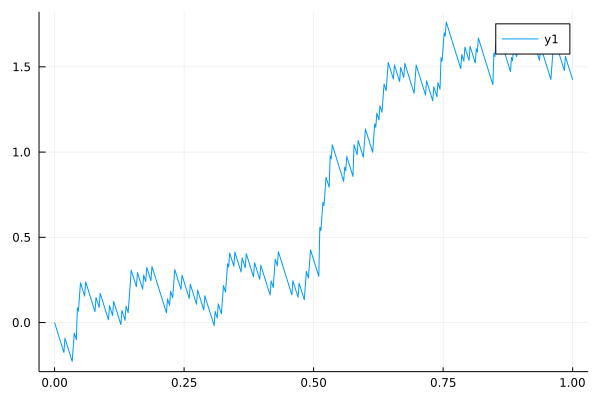

In [8]:
## Plotting the BM

n = 20
alpha = .75
mun = 10*(n^alpha)
an = 1-1/(1000*(n^alpha))
dt = 1/500
sigma = 2000
chi = 1/alpha

events = genEvents(alpha,mun,an,sigma)

kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
pointProcess(x) = counter(x,events)
intensity(x) = compensator(x,events,mun,kernel)
integratedIntensity(x) = riemannSum(x,intensity,dt)
martingale(x) = pointProcess(x) - integratedIntensity(x)

Vec = discretize(martingale,intensity,n,dt)[1]
zz = Array(0:dt:1)
plot(zz,Vec)

In [43]:
function testRescaled(alpha::Number, mu::Number, an::Number, sigma::Number, n::Number, dt::Number, lamVec::Array{<:Number}, diffVec::Array{<:Number})
    
    M = convert(Int,floor(1/dt))
    dCon = (alpha*(sigma*alpha)^alpha)*gamma(1-alpha)/alpha
    gamn = (mu*(1-an)*n)^(-.5)
    nun = (n^alpha)*(1-an)/dCon
    intC = ((1-an)/mun).*lamVec
    N = Array(1:1:M)
    ti = N .* dt
    integrand1 = zeros(M)
    integral2 = zeros(M)
    
    f(x) = x^(alpha-1)*mittleff(alpha,alpha,-nun*x^alpha)
    partial2(x1,x2) = gamn*nun*f(x1-x2*dt)*intC[convert(Int,x2)]*diffVec[convert(Int,x2)]
    
    for k in 1:M
        integrand1[k] = nun*f(ti[k])
        if k > 1
            for l in 1:(k-1)
                integral2[k] = partial2(ti[k],N[l])
            end
        else
            integral2[1] = gamn*nun*f(ti[1])*intC[1]*diffVec[1]
        end
    end
    
    partSum1 = integrand1 .* dt
    integral1 = pushfirst!(accumulate(+,partSum1),0)
    integral2 = pushfirst!(integral2,0)

## Right hand side p2866    
    
    RHS = integral1 .+ integral2
    difference = intC .- RHS
    x = 0:dt:1
    y = difference
    return plot(x,y),maximum(abs.(difference)),difference
end

testRescaled (generic function with 1 method)

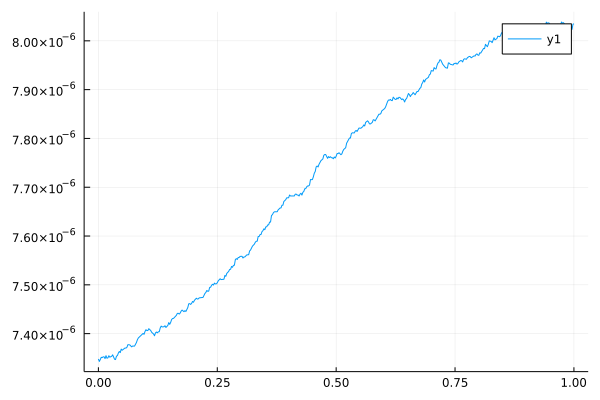

8.038580147544445e-6

In [47]:
## Testing the equation of rescaled intensity

n = 700
alpha = .75
mun = 10*(n^alpha)
an = 1-1/(1000*(n^alpha))
dt = 1/500
sigma = 2000
chi = 1/alpha

events = genEvents(alpha,mun,an,sigma)

kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
pointProcess(x) = counter(x,events)
intensity(x) = compensator(x,events,mun,kernel)
integratedIntensity(x) = riemannSum(x,intensity,dt)
martingale(x) = pointProcess(x) - integratedIntensity(x)

lamVec = discretize(martingale, intensity, n, dt)[2]
diffVec = discretize(martingale, intensity, n, dt)[3]

p = testRescaled(alpha,mun,an,sigma,n,dt,lamVec,diffVec)[1]
Plots.display(p)
testRescaled(alpha,mun,an,sigma,n,dt,lamVec,diffVec)[2]